# Proportional Historical Variance
Let's compare the relative magnitudes of the seasonal component and non-seasonal component of FG_CO2 in each region. Through climate diagnostics practices, this is quite simple: find the mean seasonal cycle historically and take the standard deviation of it ($\sigma_{s}$). Then find the mean standard deviation of all the residuals ($\sigma_{r}$). Then one can simply plot the proportion of variance explained by internal variability : $\frac{\sigma_{r}}{\sigma_{s} + \sigma{r}}$

In [55]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
plt.style.use('ocn-clim')
import cmocean.cm as cm

In [148]:
EBU = 'BenCS'

# Load in CO$_{2}$ Flux Time Series for Region

In [3]:
def load_in_filtered_data(VAR, EBU, AW=True):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any inputted variable
    and returns an xarray dataset for the forced signal, residuals, and the total time series
    (simply the sum of the two previous components).
    """
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

In [4]:
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU)
con_mean, con_resid, con_total = load_in_filtered_data('FG_CO2', EBU)

# Derive anthropogenic carbon if needed
anth_mean = con_mean['FG_CO2_AW'] - nat_mean['FG_ALT_CO2_AW']
anth_resid = con_resid['FG_CO2_AW'] - nat_resid['FG_ALT_CO2_AW']
anth_total = con_total['FG_CO2_AW'] - nat_total['FG_ALT_CO2_AW']

# (1) How much of the variability is internal vs. seasonal?
Start out by doing this with the area-weighted time series and then move on to the full domain.

In [5]:
import numpy.polynomial.polynomial as poly
def remove_polynomial_fit(data, order=4):
    x = np.arange(0, len(data), 1)
    coefs = poly.polyfit(x, data, order)
    line_fit = poly.polyval(x, coefs)
    return (data - line_fit), coefs

In [6]:
# Remove the 4th order trend just to get the zero-centered seasonality.
data = con_mean['FG_CO2_AW'].values
t = con_mean['FG_CO2_AW'].time.values
contemp_seasonality, _ = remove_polynomial_fit(data)

# Put back into xarray to easily compute the standard seasonal cycle
contemp_seasonality = xr.DataArray(contemp_seasonality, dims=['time'], coords=[t])

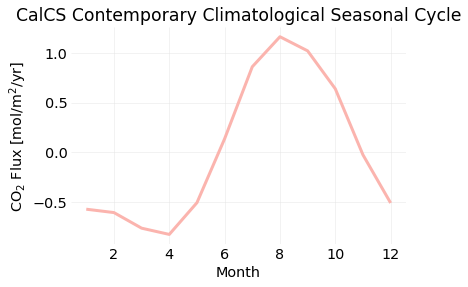

In [7]:
# Plot the climatological seasonality
fig = plt.figure()
ax = plt.subplot(111)
contemp_seasonality.groupby('time.month').mean(dim='time').plot()
ax.set_title(EBU + ' Contemporary Climatological Seasonal Cycle')
ax.set(xlabel='Month', ylabel='CO$_{2}$ Flux [mol/m$^{2}$/yr]')

In [8]:
# Compute the magnitude of this seasonal cycle.
seasonal_variance = contemp_seasonality.groupby('time.month').mean(dim='time').std()
print("The magnitude of the seasonal cycle is : " + str(seasonal_variance.values.round(3)) +
       " mol/m2/yr")

The magnitude of the seasonal cycle is : 0.71 mol/m2/yr


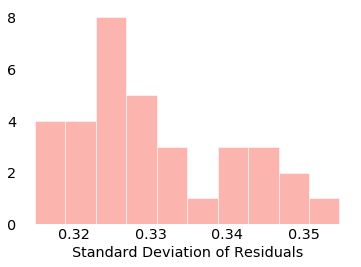

In [9]:
ax = plt.subplot(111)
residual_variance = con_resid['FG_CO2_AW'].std(dim='time')
plt.hist(residual_variance, edgecolor='w')
ax.grid('off')
ax.set(xlabel='Standard Deviation of Residuals')

Just proving a point that it's fair to take the mean standard deviation of the residuals, since they don't vary all that much simulation-to-simulation. This is being used as a metric for interannual variability.

In [10]:
residual_variance = np.mean(residual_variance)
print("The magnitude of the seasonal cycle is : " + str(residual_variance.values.round(3)) +
      " mol/m2/yr")

non_seasonal_variance = (residual_variance / (seasonal_variance + residual_variance)) * 100
print("For the " + EBU + " the non-seasonal component of variance is " + 
      str(non_seasonal_variance.values.round(2)) + "%")

The magnitude of the seasonal cycle is : 0.331 mol/m2/yr
For the CalCS the non-seasonal component of variance is 31.78%


# (2) What percentage of the historical internal variability is natural?
Use this to motivate splitting your story into natural carbon and anthropogenic carbon. Can compare the std. deviation of natural residuals and anthropogenic residuals relative to contemporary residuals

In [11]:
natural_non_seasonal = nat_resid['FG_ALT_CO2_AW'].std(dim='time').mean().values
contemp_non_seasonal = con_resid['FG_CO2_AW'].std(dim='time').mean().values

natural_internal_variance = (natural_non_seasonal / contemp_non_seasonal) * 100
print(str(natural_internal_variance.round(3)) + "% of the internally generated variability is " +
     "from natural carbon.")

86.579% of the internally generated variability is from natural carbon.


# (3) What do these two analyses look like on a grid cell basis?
Let's address point (1) and point (2) for each grid cell in the region.

In [107]:
def visual_bounds(EBU):
    """
    Zooms the map into the appropriate region for plotting the EBU of choice.
    """
    if EBU == "CalCS":
        lat1 = 34
        lat2 = 46
        lon1 = -135+360
        lon2 = -113+360
    elif EBU == 'HumCS':
        lat1 = -18
        lat2 = -4
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 10
        lat2 = 25
        lon1 = -24
        lon2 = -11
    elif EBU == 'BenCS':
        lat1 = -35
        lat2 = -15
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [159]:
def setup_map(ax, lat1, lat2, lon1, lon2):
    """
    Sets up our Basemap projection for plotting.
    """
    m = Basemap(projection='merc',
                lat_0=(lat1+lat2)/2,
                lon_0=(lon1+lon2)/2,
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                fix_aspect=False,
                resolution='c')
    m.fillcontinents(color='#D3D3D3')
    return m

In [109]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

### Computing the Relative Magnitudes

In [110]:
import numpy.polynomial.polynomial as poly
def seasonal_magnitude(ds):
    """
    This operation takes in an ensemble mean, assuming there's some seasonal cycle component
    and some trend component. It then detrends this mean with a 4th order fit to make it stationary.
    It'll finally take the standard deviation of the climatological mean seasonal cycle and return
    a grid of values that represent the magnitude of the seasonal cycle.
    """
    # We have some NaN time series here from our bounding box. 
    # Just ignore these because we can't fit them with any curve.
    if ds.min().isnull():
        return xr.DataArray(np.nan)
    else:
        # First, detrend this beast!
        x = np.arange(0, len(ds), 1)
        coefs = poly.polyfit(x, ds, 4)
        poly_fit = poly.polyval(x, coefs)
        seasonality = ds - poly_fit
        # Next, find the climatological seasonal cycle.
        magnitude = seasonality.groupby('time.month').mean().std()
        return xr.DataArray(magnitude)

In [149]:
# Bring down full grid
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU, AW=False)

In [150]:
# Compute the seasonal magnitude component
stacked = nat_mean['FG_ALT_CO2'].stack(allpoints=['nlat', 'nlon'])
operation = stacked.groupby('allpoints', squeeze=False).apply(seasonal_magnitude)
s_magnitude = operation.unstack('allpoints')

In [151]:
# Compute the mean internal magnitude component
r_magnitude = nat_resid['FG_ALT_CO2'].std(dim='time').mean(dim='ensemble')

In [152]:
# Create relative contribution.
relative_internal = (r_magnitude / (r_magnitude + s_magnitude)) * 100

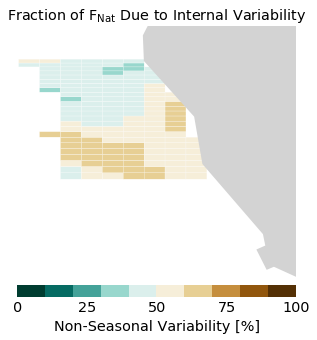

In [161]:
# Data to plot
lat = relative_internal['TLAT'].values
lon = relative_internal['TLONG'].values
data = relative_internal.to_masked_array()

# Figure Setup
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lat1,lat2,lon1,lon2 = visual_bounds(EBU)
m = setup_map(ax,lat1,lat2,lon1,lon2)

# Visualize
m.pcolor(lon-0.5, lat, data, vmin=0, vmax=100, latlon=True,
         cmap=discrete_cmap(10, 'BrBG_r'), edgecolor='w')
m.colorbar(location='bottom', ticks=[0,25,50,75,100],
          label='Non-Seasonal Variability [%]')
ax.set_title('Fraction of F$_{\mathrm{Nat}}$ Due to Internal Variability', fontsize='x-large')

# Save plot
#plt.savefig('fractional_internal_variability_FG_ALT_CO2_' + EBU + '.png',
#            bbox_inches='tight', pad_inches=1, transparent=True, dpi=300)